## Введение в ТВиМС: практикум по проверке статистических гипотез

*Алла Тамбовцева, НИУ ВШЭ*

Импортируем библиотеку `pandas` для чтения и обработки данных, хранящихся в файле Excel. Она обычно импортируется с сокращенным названием `pd`:

In [1]:
import pandas as pd

### Подготовка данных

Для работы мы будем использовать совсем свежие данные – результаты опроса на паре по Python, посвященному героям музыкальной сказки «Не покидай...» 1989 года (страница фильма будет в домашнем задании на парсинг HTML). 

Кого не было на той паре, идея опроса: 

* сначала было предложено выбрать самых интересных героев по их краткому описанию (как в пьесах, без подробностей, раскрывающих сюжет);

* потом были показаны [слайды](https://www.dropbox.com/s/s6ol9banegd365b/%D0%9D%D0%9F_%D1%81%D0%BB%D0%B0%D0%B9%D0%B4%D1%8B-05.pdf?dl=0) с кадрами из фильма с героями в разных ситуациях (видео, конечно, правильнее, но совместный просмотр сказок вместо парсинга в планы не входил);

* по итогам просмотра слайдов было предложено поставить лайки/дизлайки образам героев и сыгравшим их актерам (нравится или нет, совпало ли с ожиданиями или нет);

* по итогам знакомства с героями было предложено сделать итоговый выбор самых интересных героев.

Был запрос «посмотреть на статистику», запрос принят и обработан :)

Загружаем данные из файла `NPK.xlsx` (файл должен находиться в той же папке, что и текущий ipynb-файл) и удаляем лишний столбец `Unnamed: 0` с номером строки):

In [2]:
# по умолчанию считывается первый лист файла, он нам и нужен

survey = pd.read_excel("NPK.xlsx")
survey = survey.drop(columns = "Unnamed: 0")
survey

,id,группа,профиль,пол,Теодор,Флора,Альбина,Патрик,Пенапью,Давиль,Оттилия,Жак,Марта,Марселла,выбор1,выбор2,итог1,итог2
0,35,221_223,политология,жен,1,0,1,1,0,0,1,1,1,1,Альбина,Флора,Давиль,Оттилия
1,36,221_223,политология,жен,0,0,1,1,0,1,1,1,1,1,Давиль,Жак,Оттилия,Жак
2,37,221_223,политология,жен,0,0,1,1,0,0,1,1,1,0,Жак,0,Оттилия,Жак
3,38,221_223,политология,жен,0,1,0,1,0,0,1,1,1,1,Патрик,Пенапью,Марта,Марселла
4,39,221_223,политология,муж,0,0,0,1,0,1,1,1,0,0,Давиль,Оттилия,Давиль,Оттилия
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,409,эк,экономика,жен,1,0,0,1,0,1,1,1,1,1,Флора,Жак,Жак,Патрик
95,410,эк,экономика,жен,1,1,0,1,0,0,1,1,1,0,Флора,Марта,Флора,Оттилия
96,411,эк,экономика,муж,0,0,0,1,1,0,0,0,1,0,Альбина,Марта,Патрик,Марта
97,412,эк,экономика,жен,1,1,0,1,0,1,1,1,1,1,Патрик,Марселла,Давиль,Оттилия


Профили студентов, участвующих в опросе в разное время:

In [3]:
survey["профиль"].value_counts()

политология               36
бизнес-информатика        31
экономика                 13
психология                10
прикладная политология     9
Name: профиль, dtype: int64

Для знакомства с данными написаны две функции. Функция `get_top_heroes()` принимает на вход датафрейм (таблицу с данными, как выше) и выводит на экран пары *герой*-*число упоминаний*, отсортированные по убыванию числа упоминаний при выборе героев по их описанию и при итоговом выборе:

In [4]:
def get_top_heroes(df):
    """
    Parameters:
        df: a pandas data frame with survey results.
    Creates a list of tuples with pairs (name, count).
    Prints pairs (name, count) sorted by count, 
    in the descending order.
    """
    
    heroes = ['Теодор', 'Флора', 'Альбина', 'Патрик', 'Пенапью', 
          'Давиль', 'Оттилия', 'Жак', 'Марта', 'Марселла']
    
    # словарь start: ключи – герои, 
    # значения – число упоминаний в столбце выбор1 или выбор2
    # словарь end: ключи – герои, 
    # значения – число упоминаний в столбце итог1 или итог2
    
    start = {}
    end = {}

    for hero in heroes:
        freq1 = (df["выбор1"] == hero).sum()
        freq2 = (df["выбор2"] == hero).sum()
        start[hero] = freq1 + freq2  
        
        freq3 = (df["итог1"] == hero).sum()
        freq4 = (df["итог2"] == hero).sum()
        end[hero] = freq3 + freq4  

    # сортировка пар .items() по убыванию значения    
    start_freqs = sorted(start.items(), 
                         key = lambda x: x[1], 
                         reverse = True)
    
    end_freqs = sorted(end.items(), 
                         key = lambda x: x[1], 
                         reverse = True)
    print("По описанию:\n")
    print(*start_freqs, sep = "\n")
    print("\nИтоговый выбор:\n")
    print(*end_freqs, sep = "\n")

Функция `get_ratings()` тоже принимает на вход датафрейм, но выводит уже пары *герой*-*значение рейтинга*, отсортированные по убыванию рейтинга, где рейтинг вычисляется как число лайков минус число дизлайков, поставленных представленному актерами образу (игру по статичным кадрам, конечно, оценить не можем, ограничение нашего исследования):

In [5]:
def get_ratings(df):
    """
    Parameters:
        df: a pandas data frame with survey results.
    Creates a list of tuples with pairs (name, rating).
    Rating is calculated as #likes – #dislikes.
    Prints pairs (name, rating) sorted by rating, 
    in the descending order.
    """
    
    heroes = ['Теодор', 'Флора', 'Альбина', 'Патрик', 'Пенапью', 
          'Давиль', 'Оттилия', 'Жак', 'Марта', 'Марселла']
    
    # число строк в датафрейме – общее число опрошенных
    n = df.shape[0]
    
    # results: словарь, где ключи – имена героев,
    # значения – рейтинг = лайки - дизлайки
    
    results = {}
    
    for hero in heroes:
        likes = df[hero].sum()
        dislikes = n - likes
        rating = likes - dislikes
        results[hero] = rating
        
    freqs = sorted(results.items(), 
                   key = lambda x: x[1], 
                   reverse = True)
    print("\nРейтинг: лайки - дизлайки\n")
    print(*freqs, sep = "\n")

### Часть 1: результаты предыдущих опросов

Имитируем реальное исследование: посмотрим на результаты предыдущих аналогичных опросов для понимания контекста и генерации идей для формулировки гипотез. Отфильтруем подходящие строки датафрейма `survey`:

In [6]:
# предыдущие опросы – профиль не политология

previous = survey[survey["профиль"] != "политология"]

Запустим функции и изучим отсортированные результаты:

In [7]:
get_top_heroes(previous)
get_ratings(previous)

По описанию:

('Марта', 21)
('Жак', 16)
('Патрик', 15)
('Альбина', 12)
('Давиль', 12)
('Оттилия', 12)
('Марселла', 12)
('Флора', 10)
('Пенапью', 6)
('Теодор', 3)

Итоговый выбор:

('Оттилия', 24)
('Патрик', 20)
('Марта', 16)
('Жак', 14)
('Давиль', 11)
('Теодор', 6)
('Марселла', 6)
('Альбина', 5)
('Пенапью', 2)
('Флора', 1)

Рейтинг: лайки - дизлайки

('Марта', 53)
('Жак', 51)
('Оттилия', 35)
('Патрик', 33)
('Теодор', 21)
('Давиль', 21)
('Альбина', 17)
('Флора', 11)
('Марселла', -1)
('Пенапью', -9)


С разбивкой по полу, кому интересно:

In [8]:
# отбираем строки из previous для мужского пола

previous_male = previous[previous["пол"] == "муж"]

get_top_heroes(previous_male)
get_ratings(previous_male)

По описанию:

('Патрик', 8)
('Давиль', 7)
('Марта', 6)
('Марселла', 5)
('Пенапью', 4)
('Жак', 3)
('Альбина', 2)
('Теодор', 1)
('Оттилия', 1)
('Флора', 0)

Итоговый выбор:

('Давиль', 7)
('Патрик', 6)
('Оттилия', 5)
('Жак', 5)
('Теодор', 4)
('Марта', 4)
('Альбина', 3)
('Марселла', 3)
('Флора', 0)
('Пенапью', 0)

Рейтинг: лайки - дизлайки

('Марта', 17)
('Давиль', 15)
('Жак', 15)
('Оттилия', 13)
('Теодор', 11)
('Патрик', 7)
('Пенапью', 1)
('Флора', -1)
('Альбина', -1)
('Марселла', -1)


In [9]:
# отбираем строки из previous для женского пола

previous_female = previous[previous["пол"] == "жен"]

get_top_heroes(previous_female)
get_ratings(previous_female)

По описанию:

('Марта', 13)
('Жак', 10)
('Флора', 9)
('Оттилия', 9)
('Альбина', 7)
('Патрик', 6)
('Марселла', 6)
('Теодор', 2)
('Пенапью', 2)
('Давиль', 2)

Итоговый выбор:

('Оттилия', 16)
('Патрик', 11)
('Марта', 10)
('Жак', 5)
('Давиль', 3)
('Теодор', 2)
('Альбина', 2)
('Пенапью', 2)
('Марселла', 2)
('Флора', 1)

Рейтинг: лайки - дизлайки

('Жак', 30)
('Марта', 30)
('Патрик', 20)
('Флора', 16)
('Оттилия', 16)
('Альбина', 14)
('Теодор', 6)
('Давиль', 4)
('Марселла', 4)
('Пенапью', -6)


## Часть 2: результаты нашего опроса

Теперь посмотрим на результаты по более маленькой выборке – выборке, состоящей из студентов-политологов 1 курса. Все группы:

In [10]:
polit = survey[survey["профиль"] == "политология"]
get_top_heroes(polit)
get_ratings(polit)

По описанию:

('Давиль', 15)
('Патрик', 14)
('Жак', 13)
('Альбина', 8)
('Марта', 6)
('Пенапью', 5)
('Оттилия', 4)
('Флора', 3)
('Теодор', 2)
('Марселла', 0)

Итоговый выбор:

('Оттилия', 15)
('Жак', 13)
('Патрик', 11)
('Марта', 11)
('Давиль', 10)
('Альбина', 3)
('Марселла', 3)
('Флора', 1)
('Пенапью', 1)
('Теодор', 0)

Рейтинг: лайки - дизлайки

('Марта', 26)
('Жак', 24)
('Патрик', 22)
('Оттилия', 16)
('Альбина', 8)
('Теодор', 2)
('Давиль', -2)
('Марселла', -4)
('Флора', -12)
('Пенапью', -22)


А теперь по группам – заодно поймем, есть ли интересные отличия:

In [11]:
# группа 222

g222 = polit[polit["группа"] == 222]
get_top_heroes(g222)
get_ratings(g222)

По описанию:

('Давиль', 9)
('Патрик', 7)
('Альбина', 4)
('Пенапью', 4)
('Оттилия', 3)
('Жак', 3)
('Марта', 3)
('Теодор', 2)
('Флора', 1)
('Марселла', 0)

Итоговый выбор:

('Патрик', 7)
('Оттилия', 7)
('Марта', 6)
('Жак', 5)
('Давиль', 4)
('Альбина', 2)
('Марселла', 2)
('Пенапью', 1)
('Теодор', 0)
('Флора', 0)

Рейтинг: лайки - дизлайки

('Патрик', 12)
('Марта', 12)
('Жак', 8)
('Альбина', 6)
('Оттилия', 4)
('Давиль', 0)
('Теодор', -2)
('Марселла', -4)
('Флора', -6)
('Пенапью', -14)


In [12]:
# группы 221 и 223

g221_223 = polit[polit["группа"] == "221_223"]
get_top_heroes(g221_223)
get_ratings(g221_223)

По описанию:

('Жак', 10)
('Патрик', 7)
('Давиль', 6)
('Альбина', 4)
('Марта', 3)
('Флора', 2)
('Пенапью', 1)
('Оттилия', 1)
('Теодор', 0)
('Марселла', 0)

Итоговый выбор:

('Оттилия', 8)
('Жак', 8)
('Давиль', 6)
('Марта', 5)
('Патрик', 4)
('Флора', 1)
('Альбина', 1)
('Марселла', 1)
('Теодор', 0)
('Пенапью', 0)

Рейтинг: лайки - дизлайки

('Жак', 16)
('Марта', 14)
('Оттилия', 12)
('Патрик', 10)
('Теодор', 4)
('Альбина', 2)
('Марселла', 0)
('Давиль', -2)
('Флора', -6)
('Пенапью', -8)


С разбивкой по полу:

In [13]:
polit_male = polit[polit["пол"] == "муж"]

get_top_heroes(polit_male)
get_ratings(polit_male)

По описанию:

('Давиль', 8)
('Патрик', 7)
('Жак', 7)
('Альбина', 4)
('Пенапью', 2)
('Марта', 2)
('Оттилия', 1)
('Теодор', 0)
('Флора', 0)
('Марселла', 0)

Итоговый выбор:

('Патрик', 7)
('Жак', 7)
('Марта', 6)
('Оттилия', 5)
('Давиль', 4)
('Альбина', 1)
('Теодор', 0)
('Флора', 0)
('Пенапью', 0)
('Марселла', 0)

Рейтинг: лайки - дизлайки

('Жак', 12)
('Марта', 12)
('Патрик', 10)
('Альбина', 4)
('Оттилия', 4)
('Теодор', 0)
('Давиль', 0)
('Флора', -6)
('Марселла', -6)
('Пенапью', -8)


In [14]:
polit_female = polit[polit["пол"] == "жен"]

get_top_heroes(polit_female)
get_ratings(polit_female)

По описанию:

('Патрик', 7)
('Давиль', 7)
('Жак', 6)
('Альбина', 4)
('Марта', 4)
('Флора', 3)
('Пенапью', 3)
('Оттилия', 3)
('Теодор', 2)
('Марселла', 0)

Итоговый выбор:

('Оттилия', 10)
('Давиль', 6)
('Жак', 6)
('Марта', 5)
('Патрик', 4)
('Марселла', 3)
('Альбина', 2)
('Флора', 1)
('Пенапью', 1)
('Теодор', 0)

Рейтинг: лайки - дизлайки

('Марта', 14)
('Патрик', 12)
('Оттилия', 12)
('Жак', 12)
('Альбина', 4)
('Теодор', 2)
('Марселла', 2)
('Давиль', -2)
('Флора', -6)
('Пенапью', -14)


### Часть 3: проверка гипотезы о доле

Теперь перейдем к проверке гипотез. Начнем с долей. Для этого импортируем функцию `proportions_ztest()` из библиотеки `statsmodels`, которая проверяет гипотезу о равенстве доли числу:

In [16]:
from statsmodels.stats.proportion import proportions_ztest

Для того, чтобы сформулировать гипотезу о генеральной совокупности (а генеральная совокупность в нашем случае будет содержать всех студентов-политологов 1 курса, не только тех, которых опрашивали), обратимся к данным по предыдущим опросам. Предположим, что студенты-политологи несильно отличаются от студентов других специальностей. Тогда доля людей, которым понравился какой-нибудь определенный герой, среди всех студентов-политологов, должна несильно отличаться от доли таких людей среди студентов других специальностей. 

Зафиксируем общее число опрошенных студентов других специальностей:

In [17]:
N = previous.shape[0]
print(N)

63


Давайте выберем интересующего нас героя, введем его имя с клавиатуры, а Python выберет из датафрейма `previous` строки, где этот герой встречается в столбце `итог1` или в столбце `итог2`, и посчитает их количество. А мы затем найдем долю таких людей, поделив это число на общее число опрошенных:

In [18]:
h = input()
success = ((previous["итог1"] == h) | (previous["итог2"] == h)).sum()
print(success / N)

Давиль
0.1746031746031746


Итак, долю мы нашли. Эта доля будет у нас в нулевой гипотезе, альтернативную гипотезу пока выберем двухстороннюю (впишите долю выше вместо многоточия):

$$
H_0: p = 0.17
$$
$$
H_1: p \ne 0.17
$$

Для того, чтобы запустить тест для проверки гипотезы о равенстве доли числу, нам нужно зафиксировать объем выборки `n` и число успехов – число интересующих нас людей в этой выборке. Посчитаем число строк в датафрейме `polit` (таблица с результатами только студентов-политологов 1 курса ), а также посчитаем число строк, где в итоговом выборе указан интересующий нас герой:

In [19]:
n = polit.shape[0]
success_polit = ((polit["итог1"] == h) | (polit["итог2"] == h)).sum()
print(n, success_polit)

36 10


Все готово, запускаем тест:

In [20]:
# count – число успехов (в выборке)
# nobs – объем выборки
# value - подставляем значение из гипотезы
# alternative – тип альтернативы

proportions_ztest(count = success_polit, 
                  nobs = n, 
                  value = 0.17,
                  alternative = 'two-sided')

(1.4437643106183864, 0.1488052843361784)

Первое значение, которое выдает эта функция – это наблюдаемое значение статистики критерия, то есть $z_{набл}$, которое мы умеем считать вручную:

$$
z_{набл} = \frac{\hat{p}-p_0}{\sqrt{\frac{p_0 q_0}{n}}},
$$

где $n$ – объем выборки, $\hat{p}$ – выборочная доля, $p_0$ – значение доли, ожидаемое согласно нулевой гипотезе, а $q_0 = 1- p_0$.

Второе значение – просто p-value. Как обычно, выбираем уровень значимости $\alpha$ (или он нам дан в задаче), и если p-value превышает этот уровень значимости, нулевую гипотезу мы не отвергаем. Здесь p-value равно 0.148, на любом разумном уровне значимости (10%, 5%, 1%) нулевая гипотеза не отвергается. Значит, долю политологов, которым понравился канцлер Давиль, можно считать равной 0.17, и значит, эта долю можно считать равной доле «фанатов» канцлера среди студентов других специальностей.

Выдачу могли вы оформить и покрасивее: сохранить отдельные значения в переменные и подставить через f-строку:

In [21]:
# value - подставляем значение из гипотезы

z, pvalue = proportions_ztest(count = success_polit, 
                  nobs = n, 
                  value = 0.17,
                  alternative='two-sided')
print(f"z = {z:.3f} p-value = {pvalue:.5f}")

z = 1.444 p-value = 0.14881


Если бы альтернатива была односторонней, мы бы иначе указали ее тип (`larger` для правосторонней, `smaller` для левосторонней):

In [22]:
# value - подставляем значение из гипотезы

z, pvalue = proportions_ztest(count = success_polit, 
                  nobs = n, 
                  value = 0.17,
                  alternative='larger')
print(f"z = {z:.3f} p-value = {pvalue:.5f}")

z = 1.444 p-value = 0.07440


Логичным образом p-value оказалось в два раза меньше, чем в случае двусторонней альтернативы. Ведь теперь мы учитываем только вероятность $P(Z > 1.444)$, а не $P(Z > 1.444) + P(Z < -1.444)$.

### Часть 4: проверка гипотезы о среднем

Для проверки гипотезы о среднем нам понадобится модуль `stats` из библиотеки `scipy`:

In [23]:
from scipy import stats

Давайте проверим гипотезу о среднем возрасте актеров, снявшихся в фильме (генеральная совокупность – все актеры, не только те 10 человек, чьи роли мы рассматривали). 

Введем свои догадки о среднем возрасте с клавиатуры:

In [24]:
age_expected = int(input())
print(age_expected)

30
30


Итак, наша нулевая гипотеза и двусторонняя альтернатива (подставьте значение среднего выше):
    
$$
H_0: \mu = 30
$$
$$
H_1: \mu \ne 30
$$

Теперь вернемся к нашей выборке. В нашей выборке 10 актеров, это немного, но нестрашно, как раз понаблюдаем за эффектом малого объема выборки. Загрузим данные со второго листа файла Excel, там представлены некоторые числовые характеристики актеров по данным сайта КиноТеатр:

In [25]:
info = pd.read_excel("NPK.xlsx", 1)
info

,герой,актер,возраст,опыт,фильмография,число лайков кт,число лайков ст
0,Теодор,Вячеслав Невинный,54,30,157,143,53
1,Флора,Лидия Федосеева-Шукшина,50,31,106,99,43
2,Альбина,Варвара Владимирова,20,5,21,134,55
3,Патрик,Игорь Красавин,17,0,1,120,68
4,Пенапью,Артем Тынкасов,18,1,15,124,28
5,Давиль,Альберт Филозов,51,29,165,132,50
6,Оттилия,Регина Разума,37,13,51,121,64
7,Жак,Владимир Ставицкий,31,9,29,109,76
8,Марта,Елена Антонова,27,5,30,93,76
9,Марселла,Светлана Селезнева,23,5,47,93,38


Для проверки гипотезы о равенстве среднего числу нам понадобится функция `ttest_1samp` из модуля `stats`, которая реализует критерий Стьюдента для одной выборки:

In [26]:
# на первом месте – наша числовая выборка
# (столбец таблицы, массив, список)
# на втором – значение среднего из гипотезы – подставляем

stats.ttest_1samp(info["возраст"], popmean = 30)

Ttest_1sampResult(statistic=0.6159841215028543, pvalue=0.5531627159508599)

Первое значение, которое возвращает функция – наблюдаемое значение статистики критерия, то есть $t_{набл}$, которое мы умеем вычислять по формуле:

$$
t_{набл} = \frac{\bar{x} - a}{\frac{s}{\sqrt{n}}},
$$

где $\bar{x}$ – среднее арифметическое выборки, $a$ – значение среднего из нулевой гипотезы, $s$ – стандартное отклонение выборки, $n$ – объем выборки.

Второе значение – это p-value. Как обычно, фиксируем уровень значимости и делаем вывод о нулевой гипотезе. В нашем случае нулевая гипотеза снова не отвергается, причем при любом разумном уровне значимости (p-value больше наибольшего уровня значимости 10%, который еще приемлемо использовать в исследованиях). Значит, средний возраст актеров фильма можно считать равным 30 годам. Объективно, так и есть, если добавим туда всех остальных актеров, не только тех, которые в нашей выборке, с одной стороны, добавятся дети, а с другой – более возрастные актеры, что при усреднении даст как раз что-то в районе 30-35 лет.

### Часть 5: диаграммы рассеивания и коэффициент Пирсона

Теперь давайте посмотрим на связи между показателями в количественной шкале. Для начала построим диаграммы рассеивания. Посмотрим на связь между возрастом актеров и числом лайков, поставленных зарегистрированными пользователя сайта КиноТеатр. 

Воспользуемся методом `.scatter`, который работает на датафреймах `pandas` и построим диаграмму рассеивания для этих показателей:

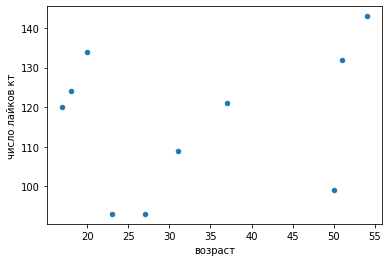

In [28]:
# info - датафрейм
# в x и y вписываем названия столбцов

info.plot.scatter(x = "возраст", y = "число лайков кт")

Конечно, малый объем выборки не позволяет делать какие-то надежные выводы, однако по графику видно, что связь между показателями, хоть и слабая, но все же положительная, прямая, с увеличением возраста число лайков увеличивается. То есть, актерам более старшего возраста пользователи более склонны ставить лайки.

Вычислим коэффициент корреляции Пирсона и проверим его значимость – гипотезу о том, что истинное значение этого коэффициента (значение для всех генеральной совокупности, для всех актеров) равно 0:

$$
H_0: R = 0 \text{ (линейной связи нет)}
$$
$$
H_1: R \ne 0 \text{ (линейная связь есть)}
$$

In [29]:
stats.pearsonr(info["возраст"], info["число лайков кт"])

(0.2415774891520072, 0.5013245713884127)

Эта функция возвращает нам два значения. Первое – это сам коэффициент Пирсона, он, действительно, положительный и не очень высокий. Второе – это p-value.  P-value здесь очень высокое, выше любого разумного уровня значимости (1%, 5%, 10%). Это значит, что у нас нет оснований отвергнуть гипотезу о равенстве истинного коэффициента корреляции нулю, что говорит об отсутствии связи. Но этот вывод довольно сомнительный, выборки в 10 наблюдений явно мало, чтобы выявить связь, если она действительно есть. 

Теперь давайте изучим взаимосвязь между возрастом актеров и числом лайков, которые поставили студенты Вышки разных специальностей:

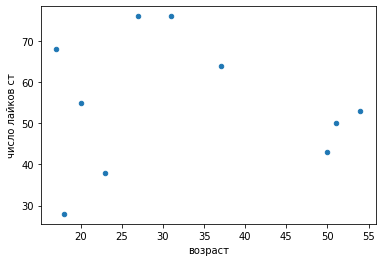

In [30]:
info.plot.scatter(x = "возраст", y = "число лайков ст")

Тут ситуация еще менее понятная, больше похоже на то, что связи нет. Но все-таки, если сравнивать с предыдущей диаграммой рассеивания, здесь график больше похож на иллюстрацию отрицательной, обратной, связи (хотя и очень слабой). То есть, у нас в исследовании все наоборот, более возрастным актерам лайки ставят реже. 

Вычислим коэффициент Пирсона и проверим наши догадки:

In [31]:
stats.pearsonr(info["возраст"], info["число лайков ст"])

(-0.04849930401725569, 0.8941569687495946)

Так и есть. Коэффициент отрицательный, но очень близок к 0, к тому же p-value говорит о том, что гипотезу от отстутствии связи отвергать не стоит.

В обоих случаях наши выводы нельзя представлять надежными. Выборки очень малы и результаты будут неточными. Более того, как обсуждалось на лекции, на малых выборках полученная оценка коэффициента чаще всего будет незначимой (связь есть, но маленький объем выборок не позволяет ее выявить, p-value будет высоким и гипотеза об отсутствии связи отвергаться не будет). Ровно это мы и наблюдали. 

Однако бывают и исключения: если связь между показателя действительно линейная и очень-очень сильная, оценка коэффициента окажется значимой даже на маленьких выборках. Например, если мы посмотрим на связь между возрастом и опытом работы в годах (на момент съемок фильма), мы обнаружим почти строгую линейную зависимость: 

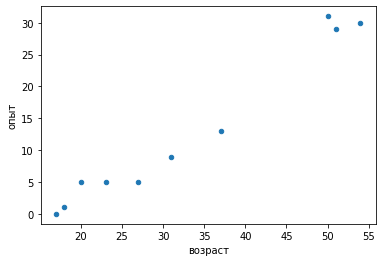

In [32]:
info.plot.scatter(x = "возраст", y = "опыт")

Коэффициент Пирсона должен получиться очень близким к 1 (сильная линейная связь), а p-value, наоборот, очень близким к 0 (данные не подтверждают нулевую гипотезу об отсутствии связи, жизнеспособность такой гипотезы почти нулевая).

Проверим!

In [33]:
stats.pearsonr(info["возраст"], info["опыт"])

(0.9820134294625925, 4.480915204632377e-07)

Так и есть, коэффициент корреляции Пирсона равен 0.98, почти строгая линейная взаимосвязь. При этом p-value примерно 0, более точно оно равно $4.48 \times 10^{-7}$. Значит, гипотеза об отсутствии линейной связи отвергается, связь есть, и она прямая. Чем выше возраст актера, тем больше у него опыта, что более чем логично.